<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Create-pycortex-vertex-objects" data-toc-modified-id="Create-pycortex-vertex-objects-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create pycortex vertex objects</a></span></li><li><span><a href="#Create-figures-etc" data-toc-modified-id="Create-figures-etc-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create figures etc</a></span></li></ul></div>

In [1]:
import cortex as cx
import platform
from pathlib import Path
import json
import nilearn.surface as surface
import pandas as pd
import numpy as np
import os, shutil, shlex, subprocess
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib import cm
import seaborn as sns
from prf_expect.utils import io

# needs prfpy for prf spatial plot, and for model predictions at some point
from prfpy.rf import gauss2D_iso_cart
from prfpy.model import Iso2DGaussianModel

In [2]:
from shutil import which
print(which("inkscape"))
os.system('inkscape --version')

None


sh: inkscape: command not found


32512

In [3]:
print('cortex.database.default_filestore: {}'.format(cx.database.default_filestore))
print('cortex.options.usercfg: {}'.format(cx.options.usercfg))

cortex.database.default_filestore: /Users/dionysus/Documents/pycortex/db
cortex.options.usercfg: /Users/dionysus/Library/Application Support/pycortex/options.cfg


### Parameters

In [4]:
hemis = ['L', 'R']
hemi_names = ['left', 'right']
model = 'norm'
prf_par_names = ['x', 'y', 'prf_size', 'prf_ampl', 'bold_bsl', 'r2']

space = 'fsaverage'
subject = 'sub-002'
need_yhat = True
need_prf = True

### Path

In [5]:
settings = io.load_settings()
data_dir = Path(settings["general"]["data_dir"], "data")

Loading settings from /Users/dionysus/Library/CloudStorage/OneDrive-Personal/Workbench/pRF_expect_pub/pRF_expect_analysis/prf_expect/settings.yml


In [6]:
cwd = os.getcwd()
prf_dir = data_dir / "derivatives" / "prf_data"
tc_L = str(prf_dir / subject / "ses-1" / "cut_and_averaged" / f"{subject}_ses-1_task-pRF_space-fsaverage_hemi-L_desc-denoised_bold_psc_mean.npy")
tc_R = str(prf_dir / subject / "ses-1" / "cut_and_averaged" / f"{subject}_ses-1_task-pRF_space-fsaverage_hemi-R_desc-denoised_bold_psc_mean.npy")
prf_pars_path = str(prf_dir / subject /  "ses-1" / "prf_fits" / "prf_params" / f"{subject}_ses-1_final-fit_space-fsaverage_model-{model}_stage-iter_desc-prf_params.tsv")
dm_fn = str(prf_dir / subject / "ses-1" / "dms" / "dm_task-pRF_run-01.npy")
pred_fn = prf_dir / subject / "ses-1" / "prf_fits" / "prf_predictions" / f"{subject}_ses-1_task-pRF_final-fit_space-fsaverage_model-{model}_stage-iter_desc-prf_pred.npy"

figure_result_dir = Path(cwd).parent / "figures"

In [7]:
vf_extent = [-5.72, 5.72]
nr_vf_pix = 200
prf_space_x, prf_space_y = np.meshgrid(np.linspace(vf_extent[0], vf_extent[1], nr_vf_pix, endpoint=True),
                                       np.linspace(vf_extent[0], vf_extent[1], nr_vf_pix, endpoint=True))

### Load data
timecourses, prf parameters, and design matrix.

In [8]:
# tc data
tc_data = np.concatenate([np.load(tc_L).T, np.load(tc_R).T])

# prf data
if need_prf:
    prf_pars_df = pd.read_csv(prf_pars_path, sep='\t', header=0)

# prediction data
if need_yhat:
    pred_data = np.load(pred_fn)

# design matrix

design_matrix = np.load(dm_fn)
dm_guideline = design_matrix.sum((0,1))
# scale dm_guideline to 0-5
dm_guideline = 5 * (dm_guideline - dm_guideline.min()) / (dm_guideline.max() - dm_guideline.min())

sos = design_matrix.sum((1,2)) != 0

In [9]:
for dm_slice in [design_matrix[:, :, 15], design_matrix[:, :, 35], design_matrix[:, :, 70], design_matrix[:, :, 90]]:
    print(dm_slice)
    print("--------------------")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
--------------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
--------------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
--------------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
--------------------


### Create pycortex vertex objects

In [10]:
pscmean_v = cx.Vertex(tc_data.mean(axis=1), subject=space, cmap='hsv')

In [11]:
prf_pars_df.keys()

Index(['x', 'y', 'prf_size', 'prf_ampl', 'bold_bsl', 'surr_ampl', 'surr_size',
       'neur_bsl', 'surr_bsl', 'A', 'B', 'C', 'D', 'ratio (B/D)', 'r2',
       'size ratio', 'suppression index', 'ecc', 'polar', 'hrf_deriv',
       'hrf_dsip'],
      dtype='object')

In [12]:

angs_n = np.array(prf_pars_df['polar'])
eccen = np.array(prf_pars_df['ecc'])
rsq = np.array(prf_pars_df['r2'])
thresh = 0.15
rsq_mask = rsq > thresh
prf_size = np.nan_to_num(np.array(prf_pars_df['prf_size']))

angs_n[rsq_mask<thresh] = np.nan
prf_size[rsq_mask<thresh] = np.nan
eccen[rsq_mask<thresh] = np.nan
rsq_mask[rsq_mask<thresh] = np.nan


### Create figures etc

In [13]:
# find best voxel (highest r2)
best_voxel = np.argmax(rsq)
print(best_voxel, rsq[best_voxel])

251134 0.9406203627586364


In [14]:
full_figsize = (6, 3)

In [15]:
# check which region the best voxel is in
rois = ('V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'LO1', 'LO2', 'VO1', 'VO2', 'hMT', 'MST', 
         'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5')
roi_verts = cx.get_roi_verts('fsaverage', rois)


In [16]:
for roi, verts in roi_verts.items():
    if best_voxel in verts:
        print(roi)

V2


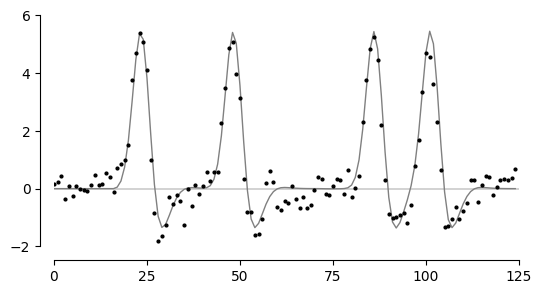

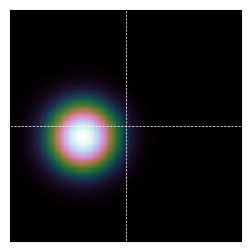

In [17]:
%matplotlib inline

timecourse_ax = plt.figure(figsize=(6, 3)).add_subplot(111)
prf_ax = plt.figure(figsize=(3, 3)).add_subplot(111)

def redraw_vertex_plots(vertex, refresh=False):
    if refresh:
        timecourse_ax.clear()
    timecourse_ax.axhline(0, color='black', lw=0.25)
    timecourse_ax.plot(pred_data[vertex], color='grey', lw=1)
    timecourse_ax.plot(tc_data[vertex], "o", markersize=2, color='black')
    timecourse_ax.set_xticks(range(0, tc_data.shape[1]+1, 25)) # set major ticks every 5 TRs
    timecourse_ax.set_xlim(0, tc_data.shape[1])
    timecourse_ax.set_ylim(-2, 6)
    timecourse_ax.set_yticks(range(-2, 7, 2))
    sns.despine(offset=10, ax=timecourse_ax)
    # timecourse_ax.set_xticklabels([])
    # timecourse_ax.set_yticklabels([])

    if prf_pars_df['prf_ampl'][vertex] != 0:
        pass

    prf = gauss2D_iso_cart(prf_space_x,
                        prf_space_y,
                        [prf_pars_df['x'][vertex],
                            prf_pars_df['y'][vertex]],
                        prf_pars_df['prf_size'][vertex])
    prf_ax.clear()
    prf_ax.matshow(prf, extent=vf_extent+vf_extent, cmap='cubehelix')
    prf_ax.axvline(0, color='white', linestyle='dashed', lw=0.5)
    prf_ax.axhline(0, color='white', linestyle='dashed', lw=0.5)
    
    prf_ax.set_xticks([])
    prf_ax.set_yticks([])
    # prf_ax.set_title(f"Vertex index: {vertex}\n" + 
    #                  f"x: {round(prf_pars_df['x'][vertex], 3)}, y: {round(prf_pars_df['y'][vertex], 3)}\n" + 
    #                  f"rsq: {round(prf_pars_df['r2'][vertex], 3)}")

def zoom_to_roi(axis, space, roi, hem, margin=10.0):
    roi_verts = cx.get_roi_verts(space, roi)[roi]
    roi_map = cx.Vertex.empty(space)
    roi_map.data[roi_verts] = 1

    (lflatpts, lpolys), (rflatpts, rpolys) = cx.db.get_surf(space, "flat",
                                                            nudge=True)
    sel_pts = dict(left=lflatpts, right=rflatpts)[hem]
    roi_pts = sel_pts[np.nonzero(getattr(roi_map, hem))[0], :2]

    xmin, ymin = roi_pts.min(0) - margin
    xmax, ymax = roi_pts.max(0) + margin
    print([xmin, xmax, ymin, ymax])
    axis.axis([xmin, xmax, ymin, ymax])

    return [xmin, xmax, ymin, ymax]

# new_bounds  = zoom_to_roi(axis=flatmap_ax, subject=subject,
#             roi='V2', hem='left', margin=10.0)

# plt.show()
# plt.ion()
redraw_vertex_plots(best_voxel)
plt.draw()
plt.show()

# save pdf
timecourse_ax.get_figure().savefig(figure_result_dir / f"{subject}_ses-1_task-pRF_space-fsaverage_desc-prf_timecourse.pdf", dpi=600, bbox_inches='tight')
prf_ax.get_figure().savefig(figure_result_dir / f"{subject}_ses-1_task-pRF_space-fsaverage_desc-prf_gauss2D_iso_cart.pdf", dpi=600, bbox_inches='tight')


In [18]:
print(f"pRFcenter for this voxel: {prf_pars_df['x'][best_voxel].round(2)}, {prf_pars_df['y'][best_voxel].round(2)}")
print(f"rsq for this voxel: {rsq[best_voxel].round(3)}")

print(f"pRFecc = {eccen[best_voxel].round(1)}°")
print(f"pRFsize = {prf_size[best_voxel].round(1)}°")
print(f"pRFangle = {np.degrees(angs_n[best_voxel]).round(1)}°")


pRFcenter for this voxel: -2.13, 0.56
rsq for this voxel: 0.941
pRFecc = 2.2°
pRFsize = 1.2°
pRFangle = 165.1°
